In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyvisa as visa
import time
import metodos_labo as labo

plt.style.use('./informes.mplstyle')

#### Identificar termocuplas

In [30]:
rm = visa.ResourceManager()
print(rm.list_resources())

multi_up = rm.open_resource('GPIB0::24::INSTR')
multi_down = rm.open_resource('GPIB0::23::INSTR')

try:
    print(multi_up.query_ascii_values('MEASURE:VOLT:DC? 0.1')[0] * 1e3)
    print(multi_down.query_ascii_values('MEASURE:RESistance? 1000')[0])
    
except:
    print('HUBO ERROR')
multi_up.close()
multi_down.close()

('GPIB0::23::INSTR', 'GPIB0::24::INSTR')
0.16849899999999998
112.39327


#### Medir temperatura ambiente

In [5]:
rm = visa.ResourceManager()
multi_down = rm.open_resource('GPIB0::23::INSTR')

try:
    
    duracion = 10  # s
    
    t = []
    R = []
    
    t0 = time.time()
    while time.time() - t0 <= duracion:
        t.append(time.time() - t0)
        R.append(multi_down.query_ascii_values('MEASURE:RESistance? 100')[0])
    
    t = np.array(t)  # s
    R = np.array(R)  # Ohm
    
    df = pd.DataFrame({'Tiempo [s]' : t,
                        'Resistencia [Ohm]' : R})
    
    labo.save(df, 'temp_amb', './Mediciones/Clase 3')
    
    
except:
    print('HUBO ERROR')
multi_down.close()

#### Medir temperaturas

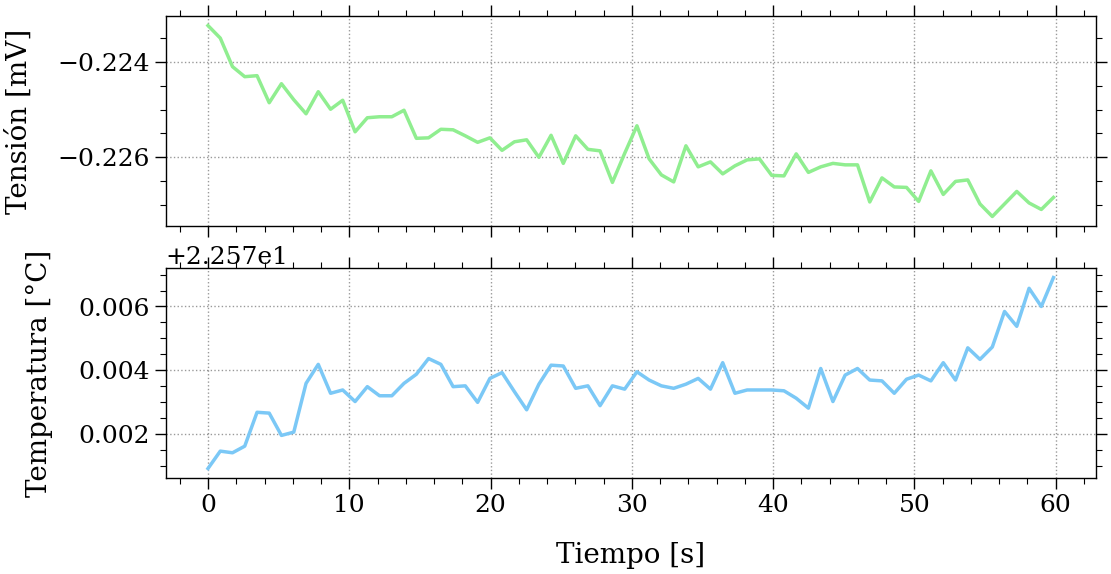

In [34]:
rm = visa.ResourceManager()

multi_up = rm.open_resource('GPIB0::24::INSTR')
multi_down = rm.open_resource('GPIB0::23::INSTR')


try:
    
    # MEDIR
    
    t = []  # s
    V = []  # V
    R = []  # Ohm
    duracion = 60  # s
    
    t0 = time.time()
    while time.time() - t0 <= duracion:
        t.append(time.time() - t0)
        medicion_V = multi_up.query_ascii_values('MEASURE:VOLT:DC? 0.1')[0]
        medicion_R = multi_down.query_ascii_values('MEASURE:RESistance? 100')[0]
        if medicion_R > 150:
            medicion_R = multi_down.query_ascii_values('MEASURE:RESistance? 1000')[0]
        
        V.append(medicion_V)
        R.append(medicion_R)
    
    t = np.array(t)  # s
    V = np.array(V) * 1e3  # mV
    R = np.array(R)  # Ohm
    
    
    # GUARDAR DATOS
    
    df = pd.DataFrame({'Tiempo [s]' : t,
                        'Tension [mV]' : V,
                        'Resistencia [Ohm]' : R})
    
    
    n_termo = 2
    labo.save(df, f'cal_termocupla{n_termo}', './Mediciones/Clase 3/Calibracion')
    
    
    # GRAFICAR
    
    fig, ax = plt.subplots(2, 1, sharex=True)
    ax[0].set_ylabel('Tensión [mV]')
    ax[1].set_ylabel('Temperatura [°C]')
    ax[1].set_xlabel('Tiempo [s]')
    
    ax[0].plot(t, V)
    ax[1].plot(t, labo.R2C(R), 'C1')
    
    
except:
    print('HUBO ERROR')
multi_up.close()
multi_down.close()

plt.show()

#### Calibración

Calibracion termocupla 1
popt = [22.61920443 28.0633875 ]
popt_sd = [0.1493859  0.18477244]
P_value = 0.4982907597746903

Calibracion termocupla 2
popt = [22.67143206 28.01350804]
popt_sd = [0.15222237 0.17485084]
P_value = 0.7655572585479274



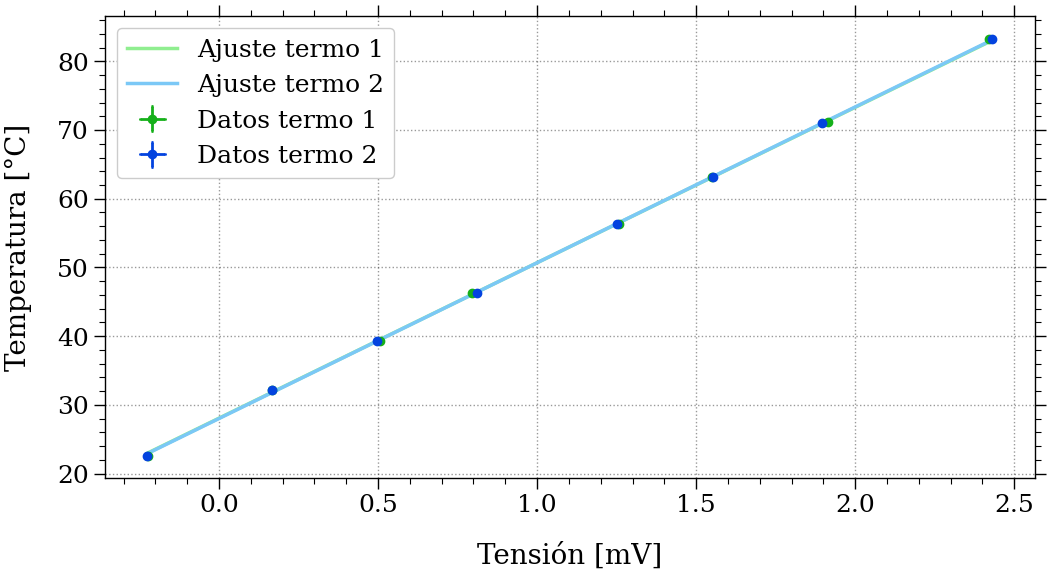

In [2]:
n_mediciones = 8
calibracion = lambda V, m, b: m*V + b

fig, ax = plt.subplots()
ax.set_xlabel('Tensión [mV]')
ax.set_ylabel('Temperatura [°C]')

colors = ['xkcd:green', 'xkcd:blue']

for n_termo in range(1, 2+1):
    
    R = []  # Resistencias [Ohm]
    V = []  # Tensiones [mV]
    R_sd = []
    V_sd = []
    
    for i in range(n_mediciones):
        if i != 0:
            df = pd.read_csv(f'./Mediciones/Clase 3/Calibracion/cal_termocupla{n_termo}({i}).csv')
        else:
            df = pd.read_csv(f'./Mediciones/Clase 3/Calibracion/cal_termocupla{n_termo}.csv')
        
        # Tension
        mediciones_V = df['Tension [mV]'].values
        sigma_mediciones_V = 0.00005*mediciones_V + 0.000035*100  # Segun manual [mV]
        
        V_bar = np.sum(mediciones_V / sigma_mediciones_V**2) / np.sum(1 / sigma_mediciones_V**2)
        sigma_V = 1 / np.sum(1 / sigma_mediciones_V**2)  # Error estadistico **2
        
        V.append(V_bar)
        V_sd.append(np.sqrt(sigma_V))
        
        
        # Resistencia
        
        mediciones_R = df['Resistencia [Ohm]'].values
        
        if i < 5:  # 100 Ohms range
            sigma_mediciones_R = 0.0001*mediciones_R + 0.00004*100  # Segun manual [Ohm]
        else:  # 1kOhm range
            sigma_mediciones_R = 0.0001*mediciones_R + 0.00001*1000  # Segun manual [Ohm]
        
        R_bar = np.sum(mediciones_R / sigma_mediciones_R**2) / np.sum(1 / sigma_mediciones_R**2)
        sigma_R = 1 / np.sum(1 / sigma_mediciones_R**2)  # Error estadistico **2
        
        R.append(R_bar)
        R_sd.append(np.sqrt(sigma_R + (mediciones_R[0] - mediciones_R[-1])**2))
    
    
    V = np.array(V)
    V_sd = np.array(V_sd)
    
    T = labo.R2C(np.array(R))
    T_sd = np.sqrt(labo.cal_pt100*np.array(R_sd))
    
    
    popt, pcov, P = labo.least_squares(calibracion, V, T, T_sd)
    print(f'Calibracion termocupla {n_termo}')
    print(f'popt = {popt}')
    print(f'popt_sd = {np.sqrt(np.diag(pcov))}')
    print(f'P_value = {P}\n')
    
    
    ax.errorbar(V, T, xerr=V_sd, yerr=T_sd, color=colors[n_termo-1], marker='o', ls='', lw=2,
                label=f'Datos termo {n_termo}', capsize=1, capthick=2)
    
    ax.plot(V, calibracion(V, *popt), label=f'Ajuste termo {n_termo}')
    


ax.legend()
plt.show()